## Load Preprocessed Data

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import xgboost
from math import floor

In [6]:
#Set seed
seed = 2022

np.random.seed(seed)

#Proportion of train/validate/test samples
proportion = [6, 2, 2]

In [7]:
#Set year
year = 2020

filename = "Data/any_chron_cond_" + str(year) + ".csv"

#Load data
df = pd.read_csv(filename, encoding='utf-8')
df.head(5)

,Unnamed: 0,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,...,QSTVER,QSTLANG,_CRACE1,_CPRACE,_CLLCPWT,_DUALUSE,_DUALCOR,_LLCPWT2,_LLCPWT,CHRON_COND
0,0,1.0,1.0,1042020,1,4,2020,1100.0,2020000001,2.020000e+09,...,10.0,1.0,NaN,NaN,NaN,1.0,0.465411,460.002849,284.335672,True
1,1,1.0,1.0,2072020,2,7,2020,1200.0,2020000002,2.020000e+09,...,10.0,1.0,NaN,NaN,NaN,1.0,0.465411,460.002849,171.283329,True
2,2,1.0,1.0,1232020,1,23,2020,1100.0,2020000003,2.020000e+09,...,10.0,1.0,NaN,NaN,NaN,1.0,0.465411,1847.859106,1334.368863,True
3,3,1.0,1.0,1092020,1,9,2020,1100.0,2020000004,2.020000e+09,...,10.0,1.0,NaN,NaN,NaN,9.0,NaN,1472.417322,1297.486618,False
4,4,1.0,1.0,1042020,1,4,2020,1100.0,2020000005,2.020000e+09,...,10.0,1.0,NaN,NaN,NaN,9.0,NaN,1472.417322,454.815127,True


In [8]:
#Returns X, y sets for train/val/test sets from input df
def split_data(df, proportion):
    #Shuffle data as otherwise df is roughly in order of survey date
    shuffled_df = sklearn.utils.shuffle(df, random_state = seed)
    
    #Split numbers based on proportions
    train_num = floor(df.shape[0] * (proportion[0] / sum(proportion)))
    val_num = floor(df.shape[0] * (proportion[1] / sum(proportion)))
    test_num = floor(df.shape[0] * (proportion[2] / sum(proportion)))
    
    #Split the df by set and X/y
    #Reference: https://stackoverflow.com/questions/40144769/how-to-select-the-last-column-of-dataframe
    train_set = shuffled_df[0:train_num]
    train_x = train_set.iloc[:,:-1]
    train_y = train_set.iloc[:,-1:]
    
    val_set = shuffled_df[train_num:train_num + val_num]
    val_x = val_set.iloc[:,:-1]
    val_y = val_set.iloc[:,-1:]
    
    test_set = shuffled_df[train_num + val_num:train_num + val_num + test_num]
    test_x = test_set.iloc[:,:-1]
    test_y = test_set.iloc[:,-1:]
    
    assert train_set.shape[0] + val_set.shape[0] + test_set.shape[0] <= shuffled_df.shape[0], "Sets contain overlap"
    
    return train_x, train_y, val_x, val_y, test_x, test_y

In [9]:
#Imputes data based on mode for NaN values
#Reference: https://stackoverflow.com/questions/30317119/classifiers-in-scikit-learn-that-handle-nan-null 
from sklearn.impute import SimpleImputer

def impute_data(train_x, train_y, val_x, val_y, test_x, test_y):
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer = imputer.fit(train_x)
    
    train_x_imp = imputer.transform(train_x)
    val_x_imp = imputer.transform(val_x)
    test_x_imp = imputer.transform(test_x)
    
    return train_x_imp, train_y, val_x_imp, val_y, test_x_imp, test_y

In [10]:
#Train model and display accuracy on test data
def train_test_model(model, train_x, train_y, test_x, test_y, model_name):
    model.fit(train_x, train_y)
    
    #predict on train/test data
    train_pred = model.predict(train_x)
    test_pred = model.predict(test_x)
    
    print(f"Accuracy Scores for Training Data using {model_name}")
    print(sklearn.metrics.accuracy_score(train_y, train_pred))
    
    print(f"Accuracy Scores for Test Data using {model_name}")
    print(sklearn.metrics.accuracy_score(test_y, test_pred)) 

In [14]:
#Split data into train/val/test X y
train_x, train_y, val_x, val_y, test_x, test_y = split_data(df, proportion)

## Train/test models

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
#Use GridSearchCV to find best hyperparameters
def best_param_results(model, model_name, params, train_x, train_y, val_x, val_y):
    train_sample = np.concatenate((train_x, val_x))
    train_sample_labels = np.concatenate((train_y, val_y))
    grid_search = GridSearchCV(model, param_grid=params, scoring='accuracy')
    grid_search.fit(train_sample, train_sample_labels)
    print(model_name + '\n')
    print(grid_search.best_params_)

In [ ]:
#XGBClassifier Hyperparameter tuning
xgb_params = [{'max_depth' : [1, 2, 3, 4, 5], 'subsample': [.10, .25, .50, .75], 'colsample_bytree': [.02, .05, .10, .15, .20], 'n_estimators': [5, 10, 25, 50, 100]}]
xgb = XGBClassifier(objective='reg:logistic')

best_param_results(xgb, "XGBoost", xgb_params, train_x, np.array(train_y).ravel(), val_x, np.array(val_y).ravel())

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost

In [24]:
%%time

#XGBoost Model

from xgboost import XGBClassifier

xgb = XGBClassifier(objective='reg:logistic')

train_test_model(xgb, train_x, np.array(train_y).ravel(), test_x, np.array(test_y).ravel(), "XGBoost")

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy Scores for Training Data using XGBoost
0.8040336022954382
Accuracy Scores for Test Data using XGBoost
0.7877374332947717
Wall time: 37.6 s


In [40]:
%%time

#XGBoost model using data imputed with mode values

xgb_imp = XGBClassifier(objective='reg:logistic')

train_test_model(xgb_imp, train_x_imputed, np.array(train_y_imputed).ravel(), test_x_imputed, np.array(test_y_imputed).ravel(), "XGBoost with SimpleImputer First")

C:\Users\Xin\anaconda3\envs\Applied_ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy Scores for Training Data using XGBoost with SimpleImputer First
0.7962425468748704
Accuracy Scores for Test Data using XGBoost with SimpleImputer First
0.7852122750059086
Wall time: 43.2 s


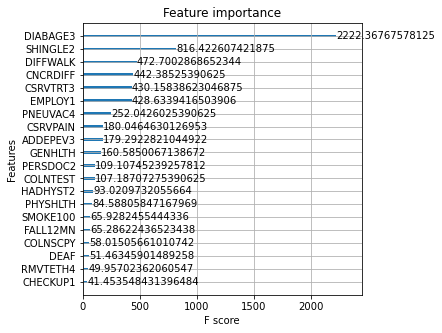

In [36]:
#View most important features for XGB with NaN
xgboost.plot_importance(xgb, max_num_features=20, importance_type='gain')

plt.show()

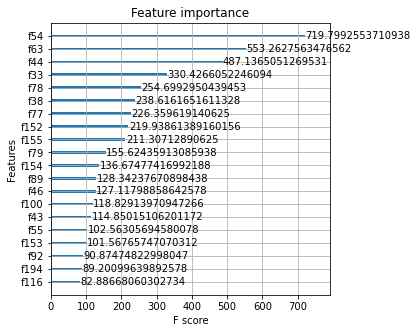

In [39]:
#View most important features for XGB with pre-imputed values
xgboost.plot_importance(xgb_imp, max_num_features=20, importance_type='gain')

plt.show()

In [15]:
#Impute values as sklearn models can't interpret NaN
train_x_imputed, train_y_imputed, val_x_imputed, val_y_imputed, test_x_imputed, test_y_imputed = impute_data(train_x, train_y, val_x, val_y, test_x, test_y)

In [51]:
#Decision Tree Hyperparam Tuning
dt_params = [{'criterion' : ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5]}]
dt = DecisionTreeClassifier()

best_param_results(dt, "Decision Tree", dt_params, train_x_imputed, np.array(train_y_imputed).ravel(), val_x_imputed, np.array(val_y_imputed).ravel())

Decision Tree

{'criterion': 'gini', 'max_depth': 5}


Accuracy Scores for Training Data using Decision Tree
0.7323840878369974
Accuracy Scores for Test Data using Decision Tree
0.7357042455001181


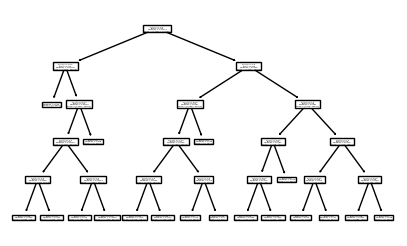

Wall time: 4.18 s


In [16]:
%%time

#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from matplotlib.pyplot import figure

dt = DecisionTreeClassifier(criterion='gini', max_depth=5)

train_test_model(dt, train_x_imputed, train_y_imputed, test_x_imputed, test_y_imputed, "Decision Tree")

#Reference: https://stackoverflow.com/questions/68973479/matplotlib-change-figure-size
figure(figsize = (5, 3), dpi = 100)
tree.plot_tree(dt)
plt.show()

In [19]:
#View most important features from Decision Tree

for i in range(0, len(dt.feature_importances_)):
    if dt.feature_importances_[i] != 0:
        print(i)
        print(dt.feature_importances_[i])

33
0.08110449534266884
34
0.0037004958834489024
44
0.28189725068612304
54
0.4581060172216447
63
0.050257679578048636
78
0.10222654816660628
95
1.7357011146499512e-05
152
0.022690156110312967


In [ ]:
#MLP Hyperparam Tuning


In [26]:
%%time

#MLP Classifier
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

#Referenced: https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected
train_test_model(mlp, train_x_imputed, np.array(train_y_imputed).ravel(), test_x_imputed, np.array(test_y_imputed).ravel(), "Multi-layer Perceptron")

Accuracy Scores for Training Data using Multi-layer Perceptron
0.4561561362335907
Accuracy Scores for Test Data using Multi-layer Perceptron
0.45911855804754265
Wall time: 8min 16s


In [ ]:
#KNN Hyperparam Tuning


In [21]:
%%time

#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)

train_test_model(knn, train_x_imputed, np.array(train_y_imputed).ravel(), test_x_imputed, np.array(test_y_imputed).ravel(), "K Nearest Neighbors")

Accuracy Scores for Training Data using K Nearest Neighbors
0.6480093210710939
Accuracy Scores for Test Data using K Nearest Neighbors
0.5403092385963603
Wall time: 24min 22s


In [ ]:
#Random Forest Hyperparam Tuning

In [29]:
%%time

#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

train_test_model(rf, train_x_imputed, np.array(train_y_imputed).ravel(), test_x_imputed, np.array(test_y_imputed).ravel(), "Random Forest")

Accuracy Scores for Training Data using Random Forest
1.0
Accuracy Scores for Test Data using Random Forest
0.7789677949024144
Wall time: 1min 54s


## Compare Models' Accuracy Scores and Runtimes

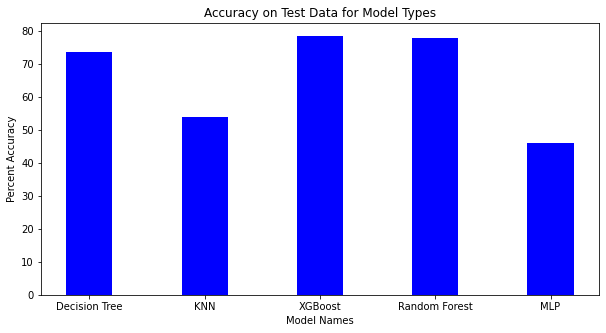

In [30]:
#Reference https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

model_acc = {'Decision Tree': 73.57, "KNN": 54.03 , 'XGBoost': 78.52, 'Random Forest': 77.89, 'MLP': 45.91}
names = list(model_acc.keys())
acc = list(model_acc.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(names, acc, color ='blue',
        width = 0.4)
 
plt.xlabel("Model Names")
plt.ylabel("Percent Accuracy")
plt.title("Accuracy on Test Data for Model Types")
plt.show()

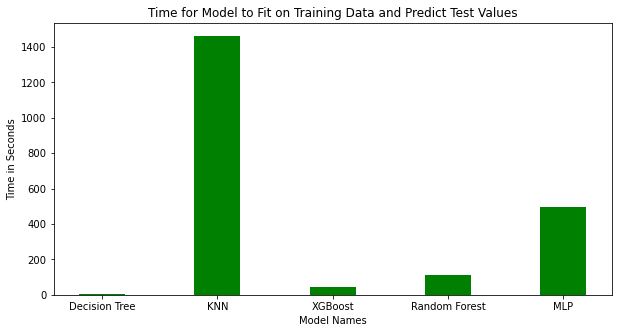

In [31]:
model_times = {'Decision Tree': 4.34, "KNN": 1462 , 'XGBoost': 43.2, 'Random Forest': 114, 'MLP': 496}
names = list(model_times.keys())
times = list(model_times.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(names, times, color ='green',
        width = 0.4)
 
plt.xlabel("Model Names")
plt.ylabel("Time in Seconds")
plt.title("Time for Model to Fit on Training Data and Predict Test Values")
plt.show()